In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from data_science import prexplo, explo, preprocessing, feature_engineering, utils
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Data reading

**source**: https://www.data.gouv.fr/fr/datasets/demandes-de-valeurs-foncieres-geolocalisees/

In [2]:
data = pd.read_csv('Data/94.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')

C:\Users\Hany\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Pre-exploration

In [3]:
df = data.copy()

In [4]:
print(df.shape)
df.head()

(52412, 40)


,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
0,2021-1181361,2021-01-04,1,Vente,203700.0,30.0,NaN,AV JEAN JAURES,4738,94100.0,94068,Saint-Maur-des-Fossés,94,NaN,NaN,94068000DI0084,NaN,NaN,35.0,42.62,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,Appartement,40.0,2.0,NaN,NaN,NaN,NaN,NaN,2.478603,48.791519
1,2021-1181362,2021-01-06,1,Vente,29500.0,6.0,NaN,AV ANATOLE FRANCE,0045,94220.0,94018,Charenton-le-Pont,94,NaN,NaN,940180000M0128,NaN,NaN,265.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0,Dépendance,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2.412382,48.823736
2,2021-1181363,2021-01-06,1,Vente,23810.0,69.0,NaN,RUE GARIBALDI,4156,94100.0,94068,Saint-Maur-des-Fossés,94,NaN,NaN,94068000CN0136,NaN,NaN,125.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0,Dépendance,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2.482007,48.797485
3,2021-1181364,2021-01-06,1,Vente,670000.0,136.0,NaN,RUE LEDRU ROLLIN,5211,94100.0,94068,Saint-Maur-des-Fossés,94,NaN,NaN,94068000DX0047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,64.0,4.0,S,sols,NaN,NaN,328.0,2.489638,48.790009
4,2021-1181365,2021-01-05,1,Vente,275000.0,15.0,NaN,RUE LOUIS BRAILLE,5271,94100.0,94068,Saint-Maur-des-Fossés,94,NaN,NaN,94068000CR0120,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0,Dépendance,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2.478553,48.802301


In [5]:
target_name = 'valeur_fonciere'

In [6]:
valeur_fonciere_crit = 500_0000
mask = (df['nature_mutation'] == 'Vente') & (df['type_local'] == 'Appartement') & (df[target_name] <= valeur_fonciere_crit)
df = df[mask]

In [7]:
print(df.shape)
prexplo.describe_columns(df)

(14745, 40)


,Type,NaN count,NaN frequency,Number of unique values
id_mutation,object,0,0.000000,13358
date_mutation,object,0,0.000000,286
numero_disposition,int64,0,0.000000,3
nature_mutation,object,0,0.000000,1
valeur_fonciere,float64,0,0.000000,3973
adresse_numero,float64,5,0.000339,257
adresse_suffixe,object,13857,0.939776,9
adresse_nom_voie,object,0,0.000000,2054
adresse_code_voie,object,0,0.000000,1220
code_postal,float64,0,0.000000,45


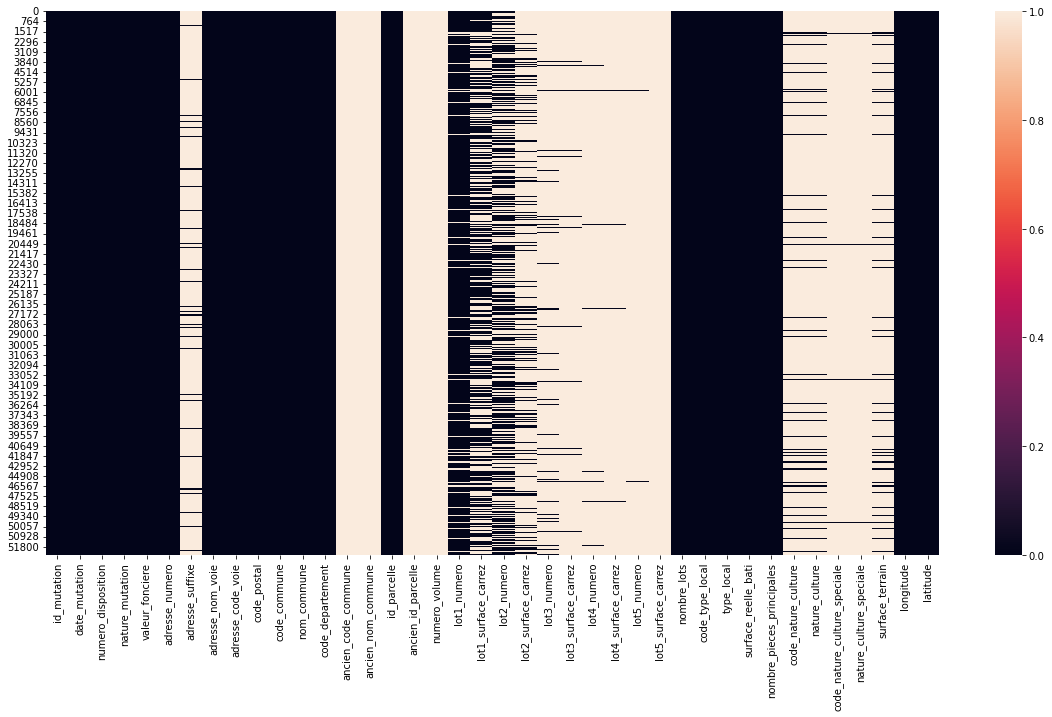

In [8]:
prexplo.nan_map(df)

## Exploration

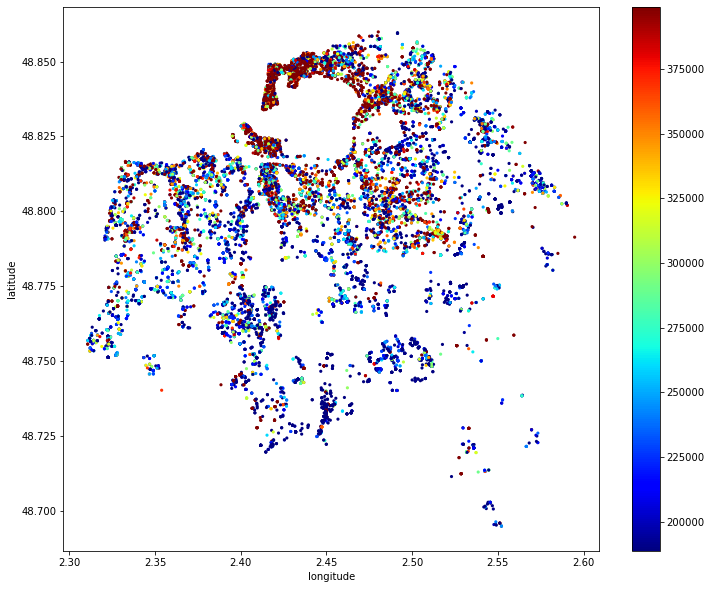

In [9]:
explo.plot_map(df, 'valeur_fonciere', lat_long=('longitude', 'latitude'))

C:\Users\Hany\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='valeur_fonciere', ylabel='Density'>

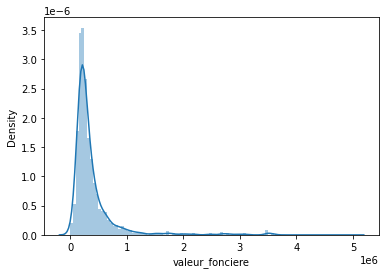

In [10]:
sns.distplot(df[target_name], bins=100)

In [11]:
df.head()

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
0,2021-1181361,2021-01-04,1,Vente,203700.0,30.0,NaN,AV JEAN JAURES,4738,94100.0,94068,Saint-Maur-des-Fossés,94,NaN,NaN,94068000DI0084,NaN,NaN,35.0,42.62,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,Appartement,40.0,2.0,NaN,NaN,NaN,NaN,NaN,2.478603,48.791519
5,2021-1181365,2021-01-05,1,Vente,275000.0,15.0,NaN,RUE LOUIS BRAILLE,5271,94100.0,94068,Saint-Maur-des-Fossés,94,NaN,NaN,94068000CR0120,NaN,NaN,37.0,NaN,72.0,45.69,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,Appartement,46.0,2.0,NaN,NaN,NaN,NaN,NaN,2.478553,48.802301
7,2021-1181366,2021-01-04,1,Vente,301000.0,169.0,B,RUE ETIENNE DOLET,3180,94140.0,94002,Alfortville,94,NaN,NaN,94002000AH0127,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,57.0,3.0,NaN,NaN,NaN,NaN,NaN,2.427946,48.784675
10,2021-1181368,2021-01-07,1,Vente,565000.0,2.0,NaN,PROM DES ANGLAIS,0125,94210.0,94068,Saint-Maur-des-Fossés,94,NaN,NaN,94068000FG0071,NaN,NaN,27.0,NaN,6.0,69.30,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,Appartement,69.0,3.0,NaN,NaN,NaN,NaN,NaN,2.520428,48.790779
11,2021-1181369,2021-01-08,1,Vente,353500.0,62.0,NaN,AV FOCH,3550,94100.0,94068,Saint-Maur-des-Fossés,94,NaN,NaN,94068000CE0109,NaN,NaN,27.0,61.95,54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,Appartement,60.0,3.0,NaN,NaN,NaN,NaN,NaN,2.493276,48.801483


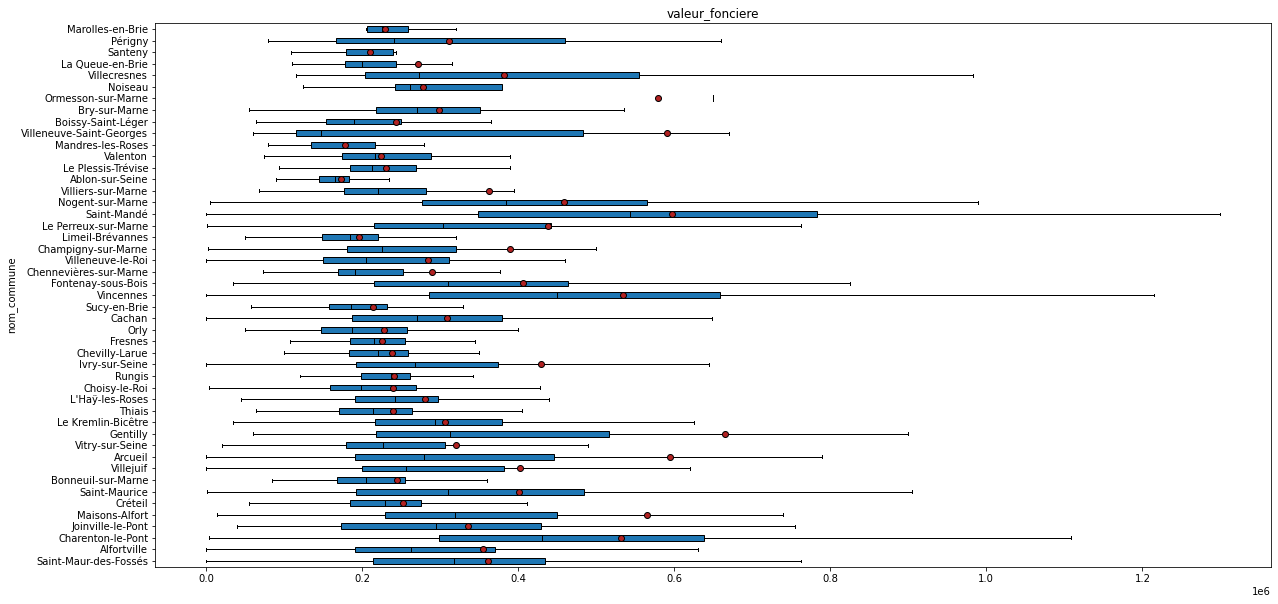

In [12]:
explo.boxplot_groupes(df, 'nom_commune', target_name)

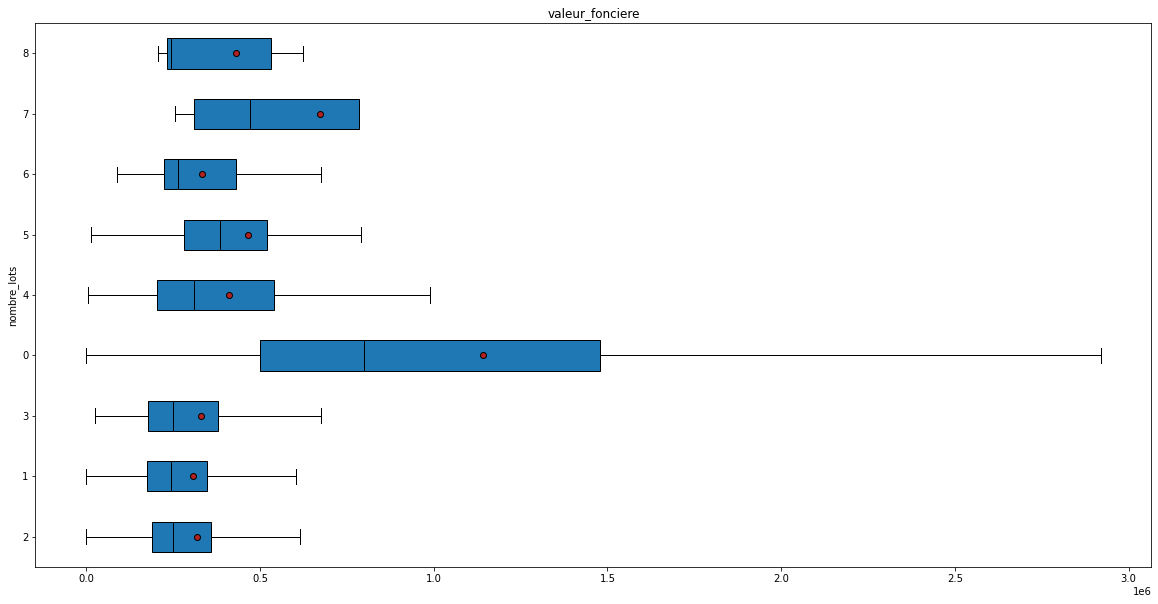

In [13]:
explo.boxplot_groupes(df, 'nombre_lots', target_name)

In [14]:
all_stations = pd.read_csv('localisation_gares_val_de_marne.csv')
all_stations.head()

,Unnamed: 0,name,longitude,latitude
0,0,Gare de Vincennes,2.433524,48.847420
1,1,Gare de Fontenay-sous-Bois,2.463901,48.843607
2,2,Gare de Nogent-sur-Marne,2.471766,48.835151
3,3,Gare de Joinville-le-Pont,2.463687,48.820405
4,4,Gare de Saint-Maur - Créteil,2.472240,48.806379


In [15]:
def get_nearest_station_distance(row):
    
    m1 = (row['longitude'], row['latitude'])
    
    min_dist = float('inf')
    
    for i in all_stations.index:
        station = all_stations.loc[i]
        m2 = tuple(station[['longitude', 'latitude']])
        
        dist = feature_engineering.distance_coords(m1, m2)
        
        min_dist = min(min_dist, dist)
        
    return min_dist * 1000

In [16]:
#df['nearest_station_distance (m)'] = df.apply(get_nearest_station_distance, axis=1)

In [17]:
df.head()

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
0,2021-1181361,2021-01-04,1,Vente,203700.0,30.0,NaN,AV JEAN JAURES,4738,94100.0,94068,Saint-Maur-des-Fossés,94,NaN,NaN,94068000DI0084,NaN,NaN,35.0,42.62,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,Appartement,40.0,2.0,NaN,NaN,NaN,NaN,NaN,2.478603,48.791519
5,2021-1181365,2021-01-05,1,Vente,275000.0,15.0,NaN,RUE LOUIS BRAILLE,5271,94100.0,94068,Saint-Maur-des-Fossés,94,NaN,NaN,94068000CR0120,NaN,NaN,37.0,NaN,72.0,45.69,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,Appartement,46.0,2.0,NaN,NaN,NaN,NaN,NaN,2.478553,48.802301
7,2021-1181366,2021-01-04,1,Vente,301000.0,169.0,B,RUE ETIENNE DOLET,3180,94140.0,94002,Alfortville,94,NaN,NaN,94002000AH0127,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,57.0,3.0,NaN,NaN,NaN,NaN,NaN,2.427946,48.784675
10,2021-1181368,2021-01-07,1,Vente,565000.0,2.0,NaN,PROM DES ANGLAIS,0125,94210.0,94068,Saint-Maur-des-Fossés,94,NaN,NaN,94068000FG0071,NaN,NaN,27.0,NaN,6.0,69.30,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,Appartement,69.0,3.0,NaN,NaN,NaN,NaN,NaN,2.520428,48.790779
11,2021-1181369,2021-01-08,1,Vente,353500.0,62.0,NaN,AV FOCH,3550,94100.0,94068,Saint-Maur-des-Fossés,94,NaN,NaN,94068000CE0109,NaN,NaN,27.0,61.95,54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,Appartement,60.0,3.0,NaN,NaN,NaN,NaN,NaN,2.493276,48.801483


## Preprocessing
- Remove useless columns
- Delete row that don't have longitude and latitude + fillna with 0, apply mask
- Get nearest station distance

In [18]:
columns_to_keep = ['valeur_fonciere', 'adresse_numero', 'nom_commune',
                   'nombre_lots', 'lot1_surface_carrez', 'lot2_surface_carrez',
       'lot3_surface_carrez','lot4_surface_carrez', 'lot5_surface_carrez','surface_reelle_bati', 'nombre_pieces_principales',
       'surface_terrain', 'longitude', 'latitude']

In [19]:
def feature_selection(df: pd.DataFrame):
    df = df[(df['nature_mutation'] == 'Vente') & (df['type_local'] == 'Appartement') & (df[target_name] <= valeur_fonciere_crit)]
    df = df.drop(['nature_mutation', 'type_local'], axis=1)
    return df[columns_to_keep]

def imputation(df: pd.DataFrame):
    df = df[(df['longitude'].notna()) | (df['latitude'].notna())]
    df = df.fillna(0)
    return df

def feature_engineering_(df: pd.DataFrame):
    df['nearest_station_distance (m)'] = df.apply(get_nearest_station_distance, axis=1)
    return df

In [20]:
PREPROCESSED_FILE_NAME = 'preprocessed_df.csv'

if os.path.exists(PREPROCESSED_FILE_NAME):
    df = pd.read_csv(PREPROCESSED_FILE_NAME)
    df.drop([col for col in df.columns if 'Unnamed' in col], axis=1, inplace=True)
else:  
    df = data.copy()
    df = feature_selection(df)
    df = imputation(df)
    df = feature_engineering_(df)
    df.to_csv(PREPROCESSED_FILE_NAME)

## Modelisation

In [21]:
x = df.drop(target_name, axis=1)
y = df[target_name]

In [22]:
encoder = preprocessing.DfEncoderOneHot()
x_encoded = encoder.fit_transform(x)
utils.save_model(encoder, 'encoder.pkl')

In [23]:
x_encoded_train, x_encoded_test, y_train, y_test = train_test_split(x_encoded, y, test_size=0.2, random_state=0)

In [24]:
scaler_y = RobustScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(len(y_train), 1))
utils.save_model(scaler_y, 'scaler_y.pkl')

In [25]:
model_class = XGBRegressor

param_grid = {f'{model_class.__name__.lower()}__learning_rate': [0.15, 0.2, 0.3],
             f'{model_class.__name__.lower()}__max_depth': [7, 10, 13],
             f'{model_class.__name__.lower()}__subsample': [0.5, 0.8, 1]}

pipeline = make_pipeline(RobustScaler(), model_class(random_state=0))
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=3, verbose=3, scoring="neg_root_mean_squared_error")

In [26]:
grid.fit(x_encoded_train, y_train_scaled.ravel())
best_params = grid.best_params_
best_params

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3] END xgbregressor__learning_rate=0.15, xgbregressor__max_depth=7, xgbregressor__subsample=0.5;, score=-0.596 total time=   2.2s
[CV 2/3] END xgbregressor__learning_rate=0.15, xgbregressor__max_depth=7, xgbregressor__subsample=0.5;, score=-0.570 total time=   2.0s
[CV 3/3] END xgbregressor__learning_rate=0.15, xgbregressor__max_depth=7, xgbregressor__subsample=0.5;, score=-0.651 total time=   1.8s
[CV 1/3] END xgbregressor__learning_rate=0.15, xgbregressor__max_depth=7, xgbregressor__subsample=0.8;, score=-0.551 total time=   1.8s
[CV 2/3] END xgbregressor__learning_rate=0.15, xgbregressor__max_depth=7, xgbregressor__subsample=0.8;, score=-0.557 total time=   1.8s
[CV 3/3] END xgbregressor__learning_rate=0.15, xgbregressor__max_depth=7, xgbregressor__subsample=0.8;, score=-0.646 total time=   1.9s
[CV 1/3] END xgbregressor__learning_rate=0.15, xgbregressor__max_depth=7, xgbregressor__subsample=1;, score=-0.521 total ti

[CV 2/3] END xgbregressor__learning_rate=0.3, xgbregressor__max_depth=7, xgbregressor__subsample=1;, score=-0.552 total time=   1.7s
[CV 3/3] END xgbregressor__learning_rate=0.3, xgbregressor__max_depth=7, xgbregressor__subsample=1;, score=-0.644 total time=   1.6s
[CV 1/3] END xgbregressor__learning_rate=0.3, xgbregressor__max_depth=10, xgbregressor__subsample=0.5;, score=-0.638 total time=   2.8s
[CV 2/3] END xgbregressor__learning_rate=0.3, xgbregressor__max_depth=10, xgbregressor__subsample=0.5;, score=-0.600 total time=   3.0s
[CV 3/3] END xgbregressor__learning_rate=0.3, xgbregressor__max_depth=10, xgbregressor__subsample=0.5;, score=-0.649 total time=   3.1s
[CV 1/3] END xgbregressor__learning_rate=0.3, xgbregressor__max_depth=10, xgbregressor__subsample=0.8;, score=-0.549 total time=   2.9s
[CV 2/3] END xgbregressor__learning_rate=0.3, xgbregressor__max_depth=10, xgbregressor__subsample=0.8;, score=-0.571 total time=   2.9s
[CV 3/3] END xgbregressor__learning_rate=0.3, xgbregre

{'xgbregressor__learning_rate': 0.2,
 'xgbregressor__max_depth': 7,
 'xgbregressor__subsample': 0.8}

In [27]:
model = pipeline.set_params(**best_params)
model.fit(x_encoded_train, y_train_scaled.ravel())

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.2,
                              max_delta_step=0, max_depth=7, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=4, num_parallel_tree=1,
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=0.8,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

## Evaluation

In [28]:
def evaluate(model, x_encoded, y_true):
    y_scaled_pred = model.predict(x_encoded)
    y_pred = scaler_y.inverse_transform(y_scaled_pred.reshape(-1, 1)).ravel()

    mae_score = mean_absolute_error(y_true, y_pred)
    rmse_score = mean_squared_error(y_true, y_pred, squared=False)
    r_sqared_score = r2_score(y_true, y_pred)
    
    print('MAE:', mae_score)
    print('RMSE:', rmse_score)
    print('R²:', r_sqared_score)
    
    return y_pred

In [29]:
print('Train set scores:')
y_pred_train = evaluate(model, x_encoded_train, y_train)
print('\nTest set scores:')
y_pred_test = evaluate(model, x_encoded_test, y_test)

Train set scores:
MAE: 37722.52997782823
RMSE: 59224.14015539649
R²: 0.9808161854548354

Test set scores:
MAE: 59309.52248971062
RMSE: 120035.80185540706
R²: 0.9250629040151306


In [30]:
utils.save_model(model, 'val_de_marne_flat_model.pkl')

In [31]:
data_parking = data[(data['type_local'] == 'Dépendance') & (data[target_name] < 30000)]

In [32]:
data_parking.head()

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
1,2021-1181362,2021-01-06,1,Vente,29500.0,6.0,NaN,AV ANATOLE FRANCE,0045,94220.0,94018,Charenton-le-Pont,94,NaN,NaN,940180000M0128,NaN,NaN,265.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0,Dépendance,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2.412382,48.823736
2,2021-1181363,2021-01-06,1,Vente,23810.0,69.0,NaN,RUE GARIBALDI,4156,94100.0,94068,Saint-Maur-des-Fossés,94,NaN,NaN,94068000CN0136,NaN,NaN,125.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0,Dépendance,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2.482007,48.797485
8,2021-1181367,2021-01-04,1,Vente,7500.0,49.0,NaN,RUE MARCEL BOURDARIAS,6123,94140.0,94002,Alfortville,94,NaN,NaN,940020000P0100,NaN,NaN,393.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0,Dépendance,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2.423462,48.807085
58,2021-1181398,2021-01-12,1,Vente,13000.0,1.0,NaN,PAS MONNIOT,6277,94210.0,94068,Saint-Maur-des-Fossés,94,NaN,NaN,94068000FG0087,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0,Dépendance,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2.519353,48.790759
65,2021-1181403,2021-01-11,1,Vente,10000.0,4.0,NaN,AV LAFERRIERE,5120,94000.0,94028,Créteil,94,NaN,NaN,940280000G0094,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0,Dépendance,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2.465256,48.805292


In [33]:
parking_group = data_parking.groupby('nom_commune')

In [34]:
median_parking = parking_group.median()
median_parking

,numero_disposition,valeur_fonciere,adresse_numero,code_postal,code_commune,code_departement,ancien_code_commune,ancien_nom_commune,ancien_id_parcelle,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude
nom_commune,,,,,,,,,,,,,,,,,,,,,,,,,,
Ablon-sur-Seine,1.0,12250.0,14.5,94480.0,94001.0,94.0,NaN,NaN,NaN,125.5,7.76,1130.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,NaN,0.0,NaN,2.418616,48.721858
Alfortville,1.0,15000.0,28.0,94140.0,94002.0,94.0,NaN,NaN,NaN,69.0,65.59,146.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,NaN,0.0,NaN,2.419296,48.806884
Arcueil,1.0,19000.0,33.0,94110.0,94003.0,94.0,NaN,NaN,NaN,254.0,NaN,308.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,NaN,0.0,NaN,2.332751,48.808453
Boissy-Saint-Léger,1.0,11000.0,6.0,94470.0,94004.0,94.0,NaN,NaN,NaN,169.0,7.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,NaN,0.0,NaN,2.507612,48.752830
Bonneuil-sur-Marne,1.0,5000.0,72.0,94380.0,94011.0,94.0,NaN,NaN,NaN,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,NaN,0.0,NaN,2.475959,48.770607
Bry-sur-Marne,1.0,13000.0,62.0,94360.0,94015.0,94.0,NaN,NaN,NaN,178.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,NaN,0.0,NaN,2.525225,48.836058
Cachan,1.0,12000.0,40.0,94230.0,94016.0,94.0,NaN,NaN,NaN,161.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,NaN,0.0,NaN,2.333353,48.791593
Champigny-sur-Marne,1.0,15000.0,83.5,94500.0,94017.0,94.0,NaN,NaN,NaN,97.0,5.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,NaN,0.0,17.0,2.500908,48.814346
Charenton-le-Pont,1.0,18500.0,17.5,94220.0,94018.0,94.0,NaN,NaN,NaN,175.0,6.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,NaN,0.0,NaN,2.410110,48.823487


In [35]:
median_parking.to_csv('median_parking.csv')